In [1]:
import os
from pathlib import Path
os.chdir(Path(os.getcwd()).parent)

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import shutil
from functools import partial

import numpy as np
import torch
from box import ConfigBox
from dvclive import Live
from dvclive.fastai import DVCLiveCallback
from fastai.data.all import Normalize, get_files
from fastai.metrics import DiceMulti
from fastai.vision.all import (Resize, SegmentationDataLoaders, aug_transforms,
                               imagenet_stats, models, unet_learner)
from ruamel.yaml import YAML
from PIL import Image

### Load data and split it into train/test

In [4]:
test_pct = 0.25

img_fpaths = get_files(Path("data") / "pool_data" / "images", extensions=".jpg")

train_data_dir = Path("data") / "train_data"
train_data_dir.mkdir(exist_ok=True)
test_data_dir = Path("data") / "test_data"
test_data_dir.mkdir(exist_ok=True)
for img_path in img_fpaths:
    msk_path = Path("data") / "pool_data" / "masks" / f"{img_path.stem}.png"
    if np.random.uniform() <= test_pct:
        shutil.copy(img_path, test_data_dir)
        shutil.copy(msk_path, test_data_dir)
    else:
        shutil.copy(img_path, train_data_dir)
        shutil.copy(msk_path, train_data_dir)

### Create a data loader

In [5]:
def get_mask_path(x, train_data_dir):
    return Path(train_data_dir) / f"{Path(x).stem}.png"

In [6]:
bs = 8
valid_pct = 0.20
img_size = 256

data_loader = SegmentationDataLoaders.from_label_func(
        path=train_data_dir,
        fnames=get_files(train_data_dir, extensions=".jpg"),
        label_func=partial(get_mask_path, train_data_dir=train_data_dir),
        codes=["not-pool", "pool"],
        bs=bs,
        valid_pct=valid_pct,
        item_tfms=Resize(img_size),
        batch_tfms=[
            *aug_transforms(size=img_size),
            Normalize.from_stats(*imagenet_stats),
        ],
    )

### Review a sample batch of data

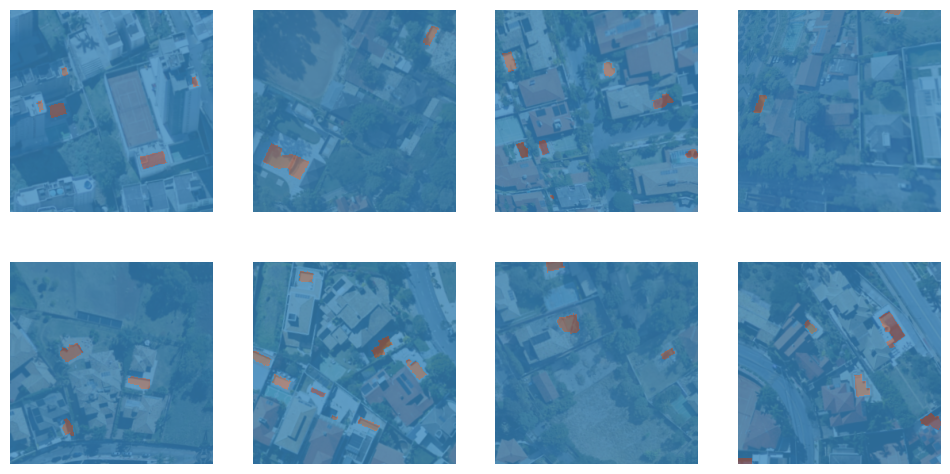

In [7]:
data_loader.show_batch(alpha=0.7)

### Train multiple models with different learning rates using `DVCLiveCallback`

In [8]:
def dice(mask_pred, mask_true, classes=[0, 1], eps=1e-6):
    dice_list = []
    for c in classes:
        y_true = mask_true == c
        y_pred = mask_pred == c
        intersection = 2.0 * np.sum(y_true * y_pred)
        dice = intersection / (np.sum(y_true) + np.sum(y_pred) + eps)
        dice_list.append(dice)
    return np.mean(dice_list)

In [9]:
train_arch = 'resnet18'

for base_lr in [0.001, 0.005, 0.01]:
    live = Live(dir=os.path.join('results', 'train'), 
            report="md", 
            save_dvc_exp=True)
    live.summary["base_lr"] =base_lr
    live.make_summary()
    learn = unet_learner(data_loader, 
                        arch=getattr(models, train_arch), 
                        metrics=DiceMulti)
    fine_tune_args = {
        'epochs': 8,
        'base_lr': base_lr
        }
    learn.fine_tune(
        **fine_tune_args,
        cbs=[DVCLiveCallback(live=live)])
    
    test_img_fpaths = get_files(Path("data") / "test_data", extensions=".jpg")
    test_dl = learn.dls.test_dl(test_img_fpaths)
    preds, _ = learn.get_preds(dl=test_dl)
    masks_pred = np.array(preds[:, 1, :] > 0.5, dtype=int)
    test_mask_fpaths = [
        get_mask_path(fpath, Path("data") / "test_data") for fpath in test_img_fpaths
    ]
    masks_true = [Image.open(mask_path) for mask_path in test_mask_fpaths]
    masks_true = [
        np.array(img.resize((img_size, img_size)), dtype=int) for img in masks_true
    ]
    with Live("results/evaluate", report="md") as live:
        dice_multi = 0.0
        for ii in range(len(masks_true)):
            mask_pred, mask_true = masks_pred[ii], masks_true[ii]
            dice_multi += dice(mask_true, mask_pred) / len(masks_true)
        live.summary["dice_multi"] = dice_multi

epoch,train_loss,valid_loss,dice_multi,time
0,0.258234,0.086672,0.495573,00:03


epoch,train_loss,valid_loss,dice_multi,time
0,0.072596,0.093680,0.517545,00:03
1,0.054957,0.023807,0.839573,00:03
2,0.044163,0.019508,0.882256,00:03
3,0.037063,0.018715,0.889783,00:03
4,0.032529,0.015020,0.915866,00:03
5,0.029384,0.015015,0.912343,00:03
6,0.026666,0.014781,0.922960,00:03
7,0.024396,0.014305,0.920746,00:03


	results/train/dvc.yaml
	results/train/dvc.yaml


epoch,train_loss,valid_loss,dice_multi,time
0,0.373197,0.081614,0.495573,00:03


epoch,train_loss,valid_loss,dice_multi,time
0,0.061678,0.041464,0.649838,00:03


In [ ]:
# Compare experiments
!dvc exp show --only-changed

In [ ]:
%%bash
# Apply best performing experiment to the workspace
BEST_EXP_NAME=$(dvc exp show --csv --sort-by dice_multi | tail -n 1 | cut -d , -f 1)
echo  "Applying $BEST_EXP_NAME"
dvc exp apply  "$BEST_EXP_NAME"

### Review sample preditions vs ground truth

In [ ]:
learn.show_results(max_n=6, alpha=0.7)

### Review instances where loss function values are the highest (i.e. model is likely to be wrong)

In [ ]:
from fastai.vision.all import SegmentationInterpretation

interp = SegmentationInterpretation.from_learner(learn)

In [ ]:
interp.plot_top_losses(k=5, alpha=0.7)